# Calculate vertical density and velocity gradients

In this notebook, the vertical gradients of density and velocity are derived. Here the resulting gradient should be on the same grid (cell centers) as the original fields. This is needed e.g. for the conversion terms in the LEC calculation.

The discrete central difference for unequal grid spacing reads as follows (however, we will test and compare this with simpler methods):

$$
\newcommand{\Dz}{\Delta z}
\newcommand{\pz}{\partial_z}
$$
\begin{align*}
\pz f|_k &= \frac{\Dz_1^2f_{k+1}+(\Dz_2^2-\Dz_1^2)f_k-\Dz_2^2f_{k-1}}{\Dz_1\Dz_2(\Dz_2+\Dz_1)}
\end{align*}
with 
\begin{align*}
\Dz_1&=z_k-z_{k-1}, & \Dz_2&=z_{k+1}-z_k  
\end{align*}

In [1]:
# Jupyter Notebook with widget matplotlib plots
#%matplotlib notebook
# Jupyter Lab with widget matplotlib plots
#%matplotlib widget 
# with Jupyter and Jupyter Lab but without widget matplotlib plots
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import sys
import pyicon as pyic
import cartopy
import seawater as sw

calc
tb
IconData
plotting
view
calc
tb
IconData
plotting
view
quickplots
quickplots


In [3]:
ccrs_proj = cartopy.crs.PlateCarree()

## Specify data set

In [4]:
run = 'nib0004'
runname = 'icon_08'
gname = 'r2b6'
lev = 'L64'

path_data     = f'/mnt/lustre01/work/mh0033/m300602/proj_vmix/icon/{runname}/icon-oes/experiments/{run}/'
path_grid     = f'/mnt/lustre01/work/mh0033/m300602/icon/grids/{gname}/'
path_ckdtree  = f'{path_grid}ckdtree/'
fpath_ckdtree = f'{path_grid}ckdtree/rectgrids/{gname}_res0.30_180W-180E_90S-90N.npz'
fpath_fx      = f'{path_grid}{gname}_{lev}_fx.nc'

In [5]:
IcD = pyic.IconData(
    fname        = run+'_????????????????.nc',
    path_data    = path_data,
    path_grid    = path_grid,
    gname        = gname,
    lev          = lev,
    do_triangulation    = False,
    omit_last_file      = False,
    calc_coeff          = False,
    calc_coeff_mappings = False,
              )

Define time frame for averaging (shorter time periods should be chosen for testing):

In [6]:
t1 = '2100-02-01'
t2 = '2101-01-01'

ic = np.argmin((IcD.clon+30)**2+(IcD.clat-26)**2)

## Loading data

Load time averaged data

In [7]:
# --- load data
uo, it_ave   = pyic.time_average(IcD, 'u', t1=t1, t2=t2, iz='all')
vo, it_ave   = pyic.time_average(IcD, 'v', t1=t1, t2=t2, iz='all')
to, it_ave   = pyic.time_average(IcD, 'to', t1=t1, t2=t2, iz='all')
so, it_ave   = pyic.time_average(IcD, 'so', t1=t1, t2=t2, iz='all')

In [8]:
to[IcD.wet_c==0] = np.ma.masked
so[IcD.wet_c==0] = np.ma.masked

In [9]:
rho_pot = sw.dens(so, to, 0.)

## Vertical density gradients

We derive the stratification (also known as Brunt-Väisälä frequency, buoyancy frequency) which is defined as
$$N^2 = -g \frac{\rho-\rho_0}{\rho_0}$$

Boundary conditions (BC): zero gradient condition is assumed at the surface and at the bottom.

Thus: $N^2(z=0)=0$ and $N^2(z=-h)=0$

This is in alignment with the ICON code: (tracer_transport/mo_ocean_tracer_transport_vert.f90 ll. 323)

In [10]:
# bottom index
kbot = IcD.wet_c.sum(axis=0).astype(int)-1
iall = np.arange(IcD.clon.size, dtype=int)

### N2 on interfaces with interpolation back to centers

Derive vertical density gradient (bouyancy frequency, $N^2$). The density values that go into the vertical density difference need to be referrenced to the same pressure value. Therefore derive them first:

In [11]:
rhop1_ = sw.dens(so[1:,:], to[1:,:], IcD.depthi[1:-1,np.newaxis])
rhom1_ = sw.dens(so[:-1,:], to[:-1,:], IcD.depthi[1:-1,np.newaxis])

In [12]:
N2 = np.ma.zeros((IcD.nz+1,to.shape[1]))
# start index from 1 => upper BC (N2(0)=0) is fullfilled
N2[1:-1,:] = - (rhom1_-rhop1_)/IcD.dzt[1:-1,:] * IcD.grav/IcD.rho0
# lower BC (N2(-h)=0):
N2[kbot+1,iall] = 0.

N2 is defined on cell interfaces, therefore interpolate back to cell centers:

In [13]:
N2vi = 0.5*(N2[1:,:]+N2[:-1,:])
N2vi[IcD.wet_c==0] = np.ma.masked

### N2 with central difference from unequal grid spacing (conceputally preferred method)

In [14]:
rho   = sw.dens(so[1:-1,:], to[1:-1,:], IcD.depthc[1:-1,np.newaxis])
rhop1 = sw.dens(so[2:,:], to[2:,:], IcD.depthc[1:-1,np.newaxis])
rhom1 = sw.dens(so[:-2,:], to[:-2,:], IcD.depthc[1:-1,np.newaxis])

In [15]:
dz1 = IcD.depthc[1:-1,np.newaxis]-IcD.depthc[:-2,np.newaxis]
dz2 = IcD.depthc[2:,np.newaxis]-IcD.depthc[1:-1,np.newaxis]
N2uesp = np.ma.zeros((IcD.nz, IcD.clon.size))
N2uesp[1:-1,:] = (dz1**2*rhop1+(dz2**2-dz1**2)*rho-dz2**2*rhom1) / (dz1*dz2*(dz2+dz1)) * IcD.grav/IcD.rho0
# N2uesp *= IcD.wet_c

Upper boundary condition assumes that $N^2(z=0)=0$ and we derive $N^2$ from interpolation between upper and lower interface of first cell:

In [16]:
N2uesp[0,:] = 0.5*(0. + (rho[0,:]-rhom1[0,:])/dz1[0] * IcD.grav/IcD.rho0)

Lower BC: $N^2(z=-h)=0$:

In [17]:
N2uesp[kbot,iall] = 0.5*( 
    (rho[kbot-2,iall]-rhop1[kbot-2,iall])
   /(IcD.depthc[kbot-1]-IcD.depthc[kbot]) * IcD.grav/IcD.rho0 + 0.)

In [18]:
N2uesp[IcD.wet_c==0] = np.ma.masked

### N2 from surface referenced potential density 

Derive N2 from potential density referenced to the surface.

!!!ATTENTION: This is not totally accurate! (But maybe still accurate enough...)

In [19]:
N2_sref = np.ma.zeros((IcD.nz+1,to.shape[1]))
N2_sref[1:-1,:] = - (rho_pot[:-1,:]-rho_pot[1:,:])/IcD.dzt[1:-1,:] * IcD.grav/IcD.rho0
N2_sref[kbot+1,iall] = 0.
# N2_sref[:-1,:] *= IcD.wet_c

N2_sref = 0.5*(N2_sref[1:,:]+N2_sref[:-1,:])
N2_sref[IcD.wet_c==0] = np.ma.masked

### N2 from surface refecenced pot. density using central differences

This method is similar as the derivation of pot. density. It also does not use density values referenced to the same pressure in the derivative.

!!!ATTENTION: This is not totally accurate! (But maybe still accurate enough...)

In [ ]:
"Vertical derivative at depth levels"
def vertical_gradient(x,d):
    z = np.ma.zeros(x.shape)
    
    if(len(x.shape)==1):
        "one dimensional array"
        z[1:-1] = (x[2:]-x[:-2])/(d[2:]-d[:-2])
        z[0]    = (x[1]-x[0])/(d[1]-d[0])
        z[-1]   = (x[-2]-x[-1])/(d[-2]-d[-1])
    else:
        z[1:-1,:] = (x[2:,:]-x[:-2,:])/(d[2:,np.newaxis]-d[:-2,np.newaxis])
        z[0,:]    = (x[1,:]-x[0,:])/(d[1,np.newaxis]-d[0,np.newaxis])
        z[-1,:]   = (x[-2,:]-x[-1,:])/(d[-2,np.newaxis]-d[-1,np.newaxis])
    return z

In [21]:
# R,_      = pyic.time_average(IcDe, 'sigma0', t1=t1, t2=t2, iz='all')
# pot = R + 1000
pot = rho_pot

In [22]:
pot[IcD.wet_c==0.] = np.ma.masked

In [23]:
# pot_am = np.sum(pot*Icon_area, axis=1)/np.sum(Icon_area, axis=1)

In [24]:
n_o = vertical_gradient(pot,IcD.depthc) * IcD.grav/IcD.rho0

### Plotting

In [25]:
N2vi[kbot[ic],ic], N2uesp[kbot[ic],ic], N2_sref[kbot[ic],ic], n_o[kbot[ic],ic]

(5.442748368252752e-09, 5.380432036772552e-09, 2.3785708958001806e-09, masked)

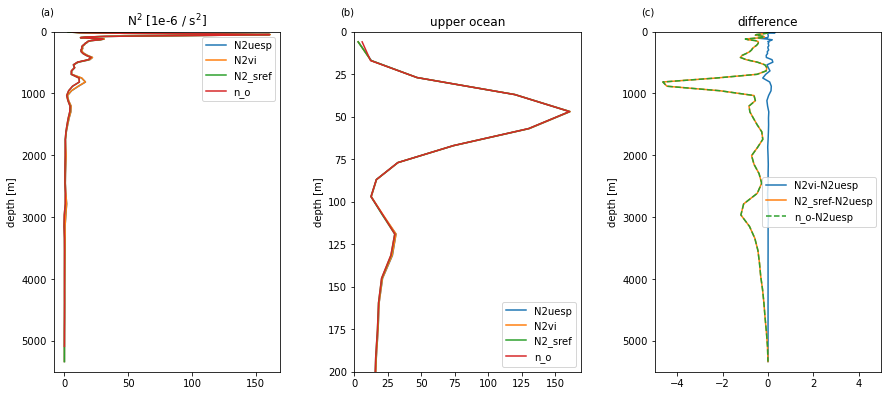

In [26]:
hca, hcb = pyic.arrange_axes(3,1, plot_cb=False, asp=1.5, fig_size_fac=3.,
                               sharex=False, sharey=False, xlabel="", ylabel="depth [m]",
                            )
ii=-1

ii+=1; ax=hca[ii]; cax=hcb[ii]
ax.plot(N2uesp[:,ic]/1e-6, IcD.depthc, label='N2uesp')
ax.plot(N2vi[:,ic]/1e-6, IcD.depthc, label='N2vi')
ax.plot(N2_sref[:,ic]/1e-6, IcD.depthc, label='N2_sref')
ax.plot(n_o[:,ic]/1e-6, IcD.depthc, label='n_o')
ax.set_ylim(5500,0)
ax.legend()
ax.set_title('N$^2$ [1e-6 / s$^2$]')

ii+=1; ax=hca[ii]; cax=hcb[ii]
ax.plot(N2uesp[:,ic]/1e-6, IcD.depthc, label='N2uesp')
ax.plot(N2vi[:,ic]/1e-6, IcD.depthc, label='N2vi')
ax.plot(N2_sref[:,ic]/1e-6, IcD.depthc, label='N2_sref')
ax.plot(n_o[:,ic]/1e-6, IcD.depthc, label='n_o')
ax.set_ylim(200,0)
ax.set_xlim(0,None)
ax.set_title('upper ocean')
ax.legend()

ii+=1; ax=hca[ii]; cax=hcb[ii]
ax.plot((N2uesp[:,ic]-N2vi[:,ic])/1e-6, IcD.depthc, label='N2vi-N2uesp')
ax.plot((N2_sref[:,ic]-N2vi[:,ic])/1e-6, IcD.depthc, label='N2_sref-N2uesp')
ax.plot((N2_sref[:,ic]-N2vi[:,ic])/1e-6, IcD.depthc, label='n_o-N2uesp', linestyle='--')
ax.set_ylim(5500,0)
ax.set_xlim(-5, 5)
ax.set_title('difference')
ax.legend()

## Vertical velocity gradients (shear)

Boundary conditions (BC): noslip boundary condition is assumed at the surface and bottom

Thus: $u(z=0)=0$ and $u(z=-h)=0$

Hower, in ICON u is not set to zero at the bottom interface but at the first land cell:

Thus for the first land cell u[kbot+1] = 0 and for the bottom interface level: ui[kbot+1] = -u[kbot]

(See ICON code: dynamics/mo_ocean_velocity_advection.f90 ll. 874)

### Shear from forward difference and interpolation to cell centers

We derive here the vertical gradient as simple centered differences. This is not totally accurate when the vert. grid spacing is uneven. Maybe this can be improved.

In [27]:
dudz = np.ma.zeros((IcD.nz+1,uo.shape[1]))
dudz[1:-1,:] = (uo[:-1,:]-uo[1:,:])/IcD.dzt[1:-1,:]
dudz[:-1,:] *= IcD.wet_c

Interpolate back from interfaces to cell centers:

In [28]:
dudzvi = 0.5*(dudz[1:,:]+dudz[:-1,:])

BC: The boundary condition is u(z=0)=0 (noslip)

In [29]:
dudzvi[0,:] = (0-uo[0,:])/IcD.dzt[0,:]

In [30]:
dudzvi[IcD.wet_c==0] = np.ma.masked

### Shear from central differences

In [31]:
dudz_cent = np.ma.zeros((IcD.nz,IcD.clon.size))
dudz_cent[1:-1,:] = (uo[:-2,:]-uo[2:,:]) / (IcD.depthc[:-2,np.newaxis]-IcD.depthc[2:,np.newaxis])

In [32]:
dudz_cent[0,:] = (0-uo[0,:])/(0-IcD.depthc[0])

In [33]:
dudz_cent[IcD.wet_c==0] = np.ma.masked

In [34]:
dudz_cent *= -1

### Shear with central difference from unequal grid spacing (conceptually preferred method)

In [35]:
uoce = uo[1:-1,:]
uop1 = uo[2:,:]
uom1 = uo[:-2,:]

In [36]:
dz1 = IcD.depthc[1:-1,np.newaxis]-IcD.depthc[:-2,np.newaxis]
dz2 = IcD.depthc[2:,np.newaxis]-IcD.depthc[1:-1,np.newaxis]
dudz_uesp = np.ma.zeros((IcD.nz, IcD.clon.size))
dudz_uesp[1:-1,:] = (dz1**2*uop1+(dz2**2-dz1**2)*uoce-dz2**2*uom1) / (dz1*dz2*(dz2+dz1))
dudz_uesp[IcD.wet_c==0] = np.ma.masked

Upper boundary condition: $u(z=0)=0$:

In [37]:
dudz_uesp[0,:] = (0-uom1[0,:])/(0-IcD.depthc[0])

Compensate for depth being positive:

In [38]:
dudz_uesp *= -1

### Plotting

In [39]:
ic = np.argmin((IcD.clon+30)**2+(IcD.clat-26)**2)

Check surface:

In [40]:
uo[:2,ic].data

array([-0.04064443, -0.01654105], dtype=float32)

In [41]:
dudz_uesp[0,ic], dudzvi[0,ic], dudz_cent[0,ic]

(0.00677407206967473, 0.00677407206967473, 0.00677407206967473)

Check bottom:

In [42]:
dudz_uesp[kbot[ic],ic], dudzvi[kbot[ic],ic], dudz_cent[kbot[ic],ic]

(6.604059746390453e-07, 5.742318762713694e-07, 6.415198308664126e-07)

Plotting

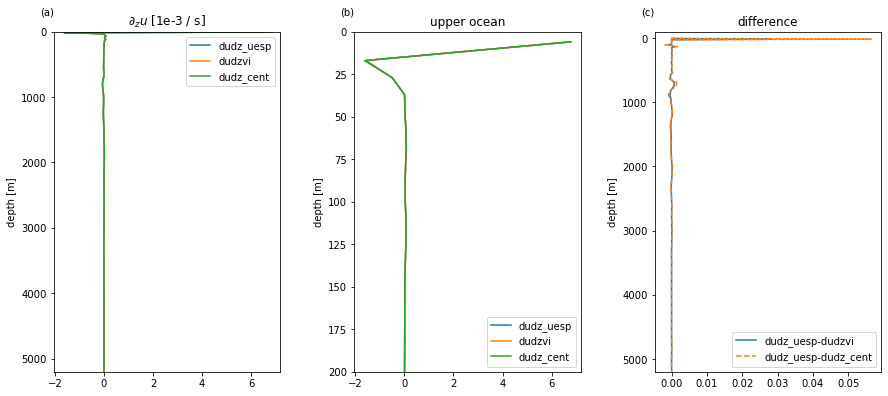

In [43]:
hca, hcb = pyic.arrange_axes(3,1, plot_cb=False, asp=1.5, fig_size_fac=3.,
                               sharex=False, sharey=False, xlabel="", ylabel="depth [m]",
                            )
ii=-1

ii+=1; ax=hca[ii]; cax=hcb[ii]
ax.plot(dudz_uesp[:,ic]/1e-3, IcD.depthc, label='dudz_uesp')
ax.plot(dudzvi[:,ic]/1e-3, IcD.depthc, label='dudzvi')
ax.plot(dudz_cent[:,ic]/1e-3, IcD.depthc, label='dudz_cent')
ax.set_ylim(5200,0)
ax.legend()
ax.set_title('$\partial_z u$ [1e-3 / s]')

ii+=1; ax=hca[ii]; cax=hcb[ii]
ax.plot(dudz_uesp[:,ic]/1e-3, IcD.depthc, label='dudz_uesp')
ax.plot(dudzvi[:,ic]/1e-3, IcD.depthc, label='dudzvi')
ax.plot(dudz_cent[:,ic]/1e-3, IcD.depthc, label='dudz_cent')
ax.set_ylim(200,0)
ax.set_xlim(None, None)
ax.set_title('upper ocean')
ax.legend()

ii+=1; ax=hca[ii]; cax=hcb[ii]
ax.plot((dudz_uesp[:,ic]-dudzvi[:,ic])/1e-3, IcD.depthc, label='dudz_uesp-dudzvi')
ax.plot((dudz_uesp[:,ic]-dudz_cent[:,ic])/1e-3, IcD.depthc, label='dudz_uesp-dudz_cent', linestyle='--')
ax.set_ylim(5200,-100)
# ax.set_xlim(-5, 5)
ax.set_title('difference')
ax.legend()